In this lab we are going to perform fine-tuning and feature transfer for dataset called Flowers 102 dataset. 
We will see how we can use large CNN already pre-trained by others on this dataset. We will compare results with just usign random weights for the filters.

##Importing libaries
Have a look especially at Keras applications

In [7]:
#General imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Keras imports
import keras

from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
import keras.backend as K

# application (model) imports
from keras import applications
#from keras.applications.inception_v3 import preprocess_input
from keras.layers import Dense
import tensorflow.keras


We created new function ***network_library*** below. It will allow us to work with commonly used architectures of CNNs 

In [8]:

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def dir_to_array(dir, image_shape, verbose=1):
  data = []
  labels = []
  image_shape = (image_shape[0], image_shape[1])
  if verbose ==1:
    bar = progressbar.ProgressBar(maxval=len(os.listdir(dir)),
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    i = 0
  for classname in os.listdir(dir):
    class_dir = os.path.join(dir, classname)
    for imagename in os.listdir(class_dir):
      data.append(np.array(load_img(os.path.join(class_dir, imagename), target_size=image_shape )))
      labels.append(int(classname)-1)
    if verbose == 1:
      i +=1
      bar.update(i)
  if verbose == 1:
    bar.finish()
  data = np.stack(data, axis=0)
  labels = np.expand_dims(np.stack(labels, axis=0), axis=1)
  return data, labels


def network_library(network_name, num_classes, weights='imagenet'):
  # Function to build keras applications 
  if network_name == 'vgg16':
    
    input_shape = (224,224,3)
    base_model = applications.vgg16.VGG16(include_top=False, weights=weights, input_shape=input_shape, pooling='max')
    preprocess_input = applications.vgg16.preprocess_input
    
    x = base_model.output
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
  elif network_name == 'inceptionv3':
    
    input_shape = (299,299,3)
    base_model = applications.inception_v3.InceptionV3(include_top = False, weights=weights, input_shape=input_shape, pooling='avg')
    preprocess_input = applications.inception_v3.preprocess_input
    
    x = base_model.output
    x = Dense(1024, activation='relu')(x) #Keras functional API
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model  = Model(inputs = base_model.inputs, outputs=predictions)
  elif network_name == 'mobilenetv2':
    
    input_shape = (224,224,3)
    base_model =  tensorflow.keras.applications.mobilenet_v2.MobileNetV2(input_shape=input_shape, alpha=1.0, include_top=False, weights=weights, pooling='avg')
    preprocess_input =  tensorflow.keras.applications.mobilenet_v2.preprocess_input
    
    x = base_model.output
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs = base_model.input, outputs=predictions)
  else:
    raise ValueError('{} is not a supported network'.format(network_name))
  return model, input_shape, preprocess_input


As we said before, for this lab we are going to have a look at a range of different ways of performing a classification on images using a convolutional neural network. We will be looking at the Flowers 102 dataset, a tricky dataset that is used very commonly in computer vision.

Lets download and unzip the data. The ! points here are telling the notebooks to run the commands in bash/terminal, these are not python commands.

In [9]:
! rm -r flower_data
! rm flower_data.zip
!wget "https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip" 
!unzip -q flower_data.zip
!ls 
! ls flower_data

--2023-03-30 01:00:45--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.18.62, 52.217.196.216, 54.231.236.248, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.18.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  33.9MB/s    in 9.5s    

2023-03-30 01:00:55 (31.3 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]

flower_data  flower_data.zip  sample_data
train  valid


Now that we have downloaded the data, lets set the data paths so that we can find the correct data folders.

The last line is just checking that the we have the same number of test classes as we have training classes

In [10]:
# set the data paths
train_dir = 'flower_data/train/'
test_dir = 'flower_data/valid'

# find the number of classes
num_classes = len(os.listdir(train_dir))

# check that the training and testing classes are the same
assert sorted(os.listdir(train_dir)) == sorted(os.listdir(test_dir))


print(num_classes)

102


Before importing the data into python lets have a look at the model we will be using.


We will be demonstrating using the [mobilenetv2 network ](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html), but you can also select [VGG16](https://neurohive.io/en/popular-networks/vgg16/) network or[ InceptionV3](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202) These networks are built into keras and is easy to use through the [applications toolkit](https://keras.io/applications/).

You are welcome to use a different network that is part of the applications toolkit.

In [11]:
# select which model you would like to use here
# Currently you can use mobilenetv2, inceptionv3 or vgg16
model_to_use = 'mobilenetv2'
weights= 'imagenet'

model, image_shape, preprocess_input = network_library(model_to_use, num_classes, weights=weights)

model.summary()
print(image_shape)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

The reason we are defining the model before we import the data is because we are going to use a specific set of weights for our model. These weights have been found by training the network on a very large dataset of general images. This large dataset is called [ImageNet](http://www.image-net.org/).

We can see above that the normal network has an input shape of (224,224,3) so in order to use the ImageNet weights we need to import each of our images at that size

Using a function defined above we can import our data from the directories to numpy arrays.

Data is finally preprocessed to the correct format expected by the network.

[                                                                        ] N/A%

Importing training data...


[========================================================================] 100%
[====                                                                    ]   5%

Importing testing data...


[========================================================================] 100%


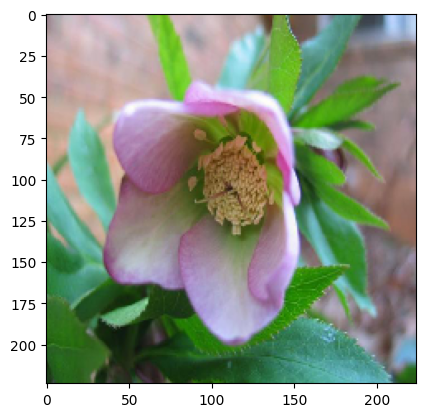

In [12]:

print('Importing training data...')
train_data_all, train_labels_all = dir_to_array(train_dir, image_shape)

print('Importing testing data...')
test_data, test_labels = dir_to_array(test_dir, image_shape)



# This line is just selecting a subset of the training data to work with.
# It is done here so that training is faster, however normally you would not be dumping most of the training data!
#Taking only 0.2 of training data here
_, train_data, _, train_labels = train_test_split(train_data_all, train_labels_all, test_size=0.2, random_state=42, stratify=train_labels_all)
plt.imshow(train_data[900])

#train_data = train_data.astype('float32')/255.
#test_data = test_data.astype('float32')/255.
train_data = preprocess_input(train_data)
test_data = preprocess_input(test_data)

As per usual, lets check the dimension of our data to ensure that everything has gone smoothly and have a look at one of the images

In [13]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(1311, 224, 224, 3)
(1311, 1)
(818, 224, 224, 3)
(818, 1)


Just doing some memory tidying up

In [14]:
import gc
gc.collect()

17609

Here, we use familiar one-hot encoding for our labels

In [15]:
print("First 5 training labels: ", train_labels[:5]) 

y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [[76]
 [43]
 [72]
 [26]
 [88]]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Finally, all preparations are done and we can compile our model. Notice small learning rate, in general we use small learning rates in fine-tuning. In summary, we compile a model here which is MobileNetv2 and with weigths after pre-training on ImageNet

In [16]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

Let's train our model!

In [17]:
history = model.fit(train_data, y_train, batch_size=16, epochs=20, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(test_data, y_test, verbose=False)

Epoch 1/20
74/74 [==============================] - 43s 114ms/step - loss: 4.3900 - accuracy: 0.0840 - val_loss: 4.4431 - val_accuracy: 0.0606
Epoch 2/20
74/74 [==============================] - 5s 74ms/step - loss: 2.8748 - accuracy: 0.4750 - val_loss: 3.8529 - val_accuracy: 0.1591
Epoch 3/20
74/74 [==============================] - 5s 73ms/step - loss: 1.8668 - accuracy: 0.7023 - val_loss: 3.2624 - val_accuracy: 0.2803
Epoch 4/20
74/74 [==============================] - 6s 75ms/step - loss: 1.2134 - accuracy: 0.8889 - val_loss: 2.8341 - val_accuracy: 0.3636
Epoch 5/20
74/74 [==============================] - 5s 73ms/step - loss: 0.7754 - accuracy: 0.9652 - val_loss: 2.4831 - val_accuracy: 0.4318
Epoch 6/20
74/74 [==============================] - 6s 77ms/step - loss: 0.4847 - accuracy: 0.9873 - val_loss: 2.1769 - val_accuracy: 0.5379
Epoch 7/20
74/74 [==============================] - 6s 78ms/step - loss: 0.3256 - accuracy: 0.9975 - val_loss: 1.9532 - val_accuracy: 0.6439
Epoch 8/20


And let's see the results! We do look at test set here as well. But if you compare the results of multiple settings (hyperparameter tuning) on the same dataset, you should only do in the very end!

Test loss: 0.736
Test accuracy: 0.833


<Figure size 800x600 with 0 Axes>

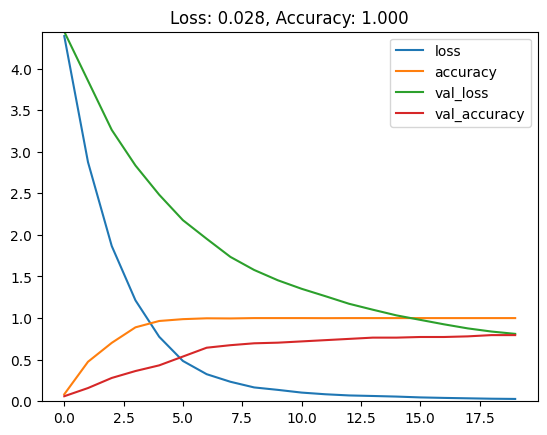

In [18]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

We can say that this particular network would benifit from further training. 

Now lets compare to training the same model using randomly initialized weights

In [19]:

weights= None


model, image_shape, preprocess_input = network_library(model_to_use, num_classes, weights=weights)

Here we have set the weights to be None, this tells Keras that we want random weights. Let's compile and train using the same optimizer and learning rate as before. (we did not need to set the "model_to_use " again because we want to use the same model as before)

In [20]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

And training!

In [21]:
history = model.fit(train_data, y_train, batch_size=16, epochs=20, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(test_data, y_test, verbose=False)

Epoch 1/20
74/74 [==============================] - 31s 86ms/step - loss: 4.6241 - accuracy: 0.0373 - val_loss: 4.6238 - val_accuracy: 0.0076
Epoch 2/20
74/74 [==============================] - 6s 75ms/step - loss: 4.3651 - accuracy: 0.0594 - val_loss: 4.6213 - val_accuracy: 0.0000e+00
Epoch 3/20
74/74 [==============================] - 5s 74ms/step - loss: 4.2678 - accuracy: 0.0696 - val_loss: 4.6192 - val_accuracy: 0.0000e+00
Epoch 4/20
74/74 [==============================] - 6s 77ms/step - loss: 4.1616 - accuracy: 0.0763 - val_loss: 4.6170 - val_accuracy: 0.0000e+00
Epoch 5/20
74/74 [==============================] - 6s 77ms/step - loss: 4.0207 - accuracy: 0.1001 - val_loss: 4.6155 - val_accuracy: 0.0076
Epoch 6/20
74/74 [==============================] - 6s 75ms/step - loss: 3.8901 - accuracy: 0.1026 - val_loss: 4.6139 - val_accuracy: 0.0152
Epoch 7/20
74/74 [==============================] - 5s 71ms/step - loss: 3.7774 - accuracy: 0.1179 - val_loss: 4.6140 - val_accuracy: 0.0152


Test loss: 4.69
Test accuracy: 0.0342


<Figure size 800x600 with 0 Axes>

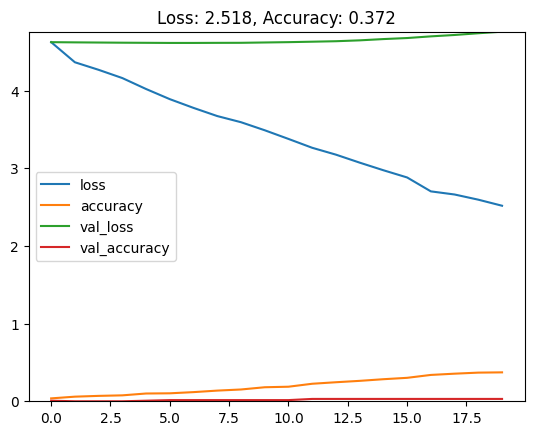

In [22]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

This takes much much longer to start learning. 

The difference between these models is that one has weights that are known to work well for general image recognition. 
Using these "good weights" means our network starts with some knowledge taken from some other task. This is called **fine-tuning**.

Next, lets have a look at **transfer learning** where we do not need to conduct a long CNN training run at all.

First we initialize a model using the pre-trained weights we had before

In [23]:
model_to_use ='vgg16' # change the model here if you like

def build_extraction_model(model_to_use):
  if model_to_use == 'vgg16':
    extraction_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=image_shape, pooling='max')
  elif model_to_use == 'inceptionv3':
    extraction_model = tensorflow.keras.applications.inception_v3.InceptionV3(include_top = False, weights='imagenet', input_shape=image_shape, pooling='avg')
  elif model_to_use == 'mobilenetv2':
    extraction_model = tensorflow.keras.applications.applications.mobilenet_v2.MobileNetV2(input_shape=image_shape, alpha=1.0, include_top=False, weights='imagenet', pooling='avg')
  return extraction_model

extraction_model = build_extraction_model(model_to_use)

train_features = extraction_model.predict(train_data)
test_features = extraction_model.predict(test_data)

26/26 [==============================] - 5s 205ms/step


The shape of our features shapes is a the same as the model's last layer output shape.

In [24]:
print("Train features shape: {}".format(train_features.shape))
print("Test features shape: {}".format(test_features.shape))
print("Model's last layer shape: {}".format(extraction_model.layers[-1].output_shape))

Train features shape: (1311, 512)
Test features shape: (818, 512)
Model's last layer shape: (None, 512)


Now let's have a look at what our features matrix looks like.

In [25]:
example = 0
print(train_features[example])

[ 2.2942767   0.          1.6633103   0.7565121   0.66741025  0.
  0.          0.88961005  0.99420905  1.3454065   0.          0.07168065
  0.49195358  0.          0.02887995  1.2961118   0.20674321  1.0496827
  0.19565752  0.          0.5288281   0.6621693   0.          2.5779445
  1.5596353   0.          1.5250885   0.9341481   0.8115189   1.7476553
  0.5327485   1.0086026   1.6641545   1.1848532   0.6527022   0.04416592
  0.58286977  0.8310992   0.          1.7066936   0.1308048   0.5834785
  0.8078723   1.2842311   1.6203371   0.5503491   0.72591364  0.8887447
  0.92281795  2.0116408   1.9893786   0.          0.19592828  1.4458535
  0.12052929  1.2069931   2.5368114   0.22291483  0.6741909   2.4976838
  3.2179503   1.0787321   0.53968567  2.7023911   1.0842394   0.55895305
  1.7690592   1.4007318   0.          0.37266803  0.20540127  1.4866886
  2.0005906   1.1644262   0.          0.3688135   1.2499316   0.50028944
  0.          0.24112317  1.1386837   0.04427779  0.9188169   1.141

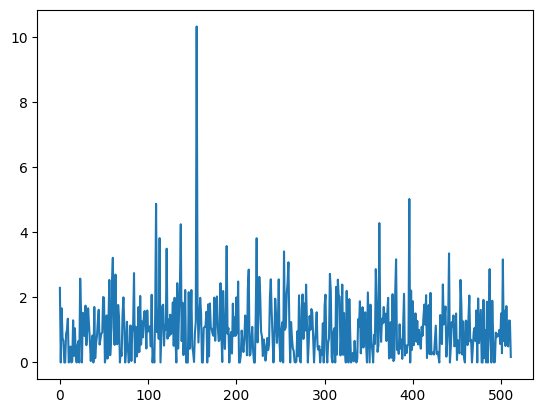

In [26]:
plt.plot(train_features[example])

If we want to, we can normalize or reduce the dimension of our feature vectors

In [27]:
normalize_data = False
pca_reduce = False
n_components = 2

if normalize_data:
  train_features = normalize(train_features)
  test_features = normalize(test_features)

if pca_reduce:
  pca_transform = PCA(n_components= n_components, whiten=True)

  train_features = pca_transform.fit_transform(train_features)
  test_features = pca_transform.transform(test_features)

So, we have used the knowlege from a general image recognition task, to transform our images into feature vectors. 
Let's try out a bunch of different classification techniques to classify them.

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

classifiers = {'Logistic regression'
               'Linear discriminant analysis':LinearDiscriminantAnalysis(),
               'Support vector RBF':SVC(gamma='auto'),
               'Support vector POLY': SVC(kernel='poly', gamma='auto'),
               'Gauusian naive bayes': GaussianNB(),
               'K-nearest neighbour':KNeighborsClassifier()}

for clf_name, clf in classifiers.items():
  clf.fit(train_features, np.squeeze(train_labels))
  acc = clf.score(test_features, np.squeeze(test_labels))
  print( 'The {} classifier got an accuracy of : {}'.format(clf_name, acc))



The Logistic regressionLinear discriminant analysis classifier got an accuracy of : 0.5660146699266504
The Support vector RBF classifier got an accuracy of : 0.46577017114914426
The Support vector POLY classifier got an accuracy of : 0.6589242053789731
The Gauusian naive bayes classifier got an accuracy of : 0.2885085574572127
The K-nearest neighbour classifier got an accuracy of : 0.5036674816625917


We could even train a different neural network to classify these new feature vectors

In [29]:
feature_size = train_features.shape[1]

small_network = Sequential()

small_network.add(Dense(64,input_shape = (feature_size,), activation='relu'))
small_network.add(Dense(64, activation='relu'))
small_network.add(Dense(num_classes, activation='softmax'))

small_network.compile('Adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = small_network.fit(train_features, y_train, batch_size=16, epochs=20, validation_split=0.1)
loss, accuracy  = small_network.evaluate(test_features, y_test, verbose=False)

Epoch 1/20
74/74 [==============================] - 2s 7ms/step - loss: 4.5739 - accuracy: 0.0441 - val_loss: 4.4139 - val_accuracy: 0.0606
Epoch 2/20
74/74 [==============================] - 0s 4ms/step - loss: 4.1699 - accuracy: 0.0967 - val_loss: 4.1221 - val_accuracy: 0.0758
Epoch 3/20
74/74 [==============================] - 0s 4ms/step - loss: 3.6052 - accuracy: 0.1798 - val_loss: 3.6572 - val_accuracy: 0.1667
Epoch 4/20
74/74 [==============================] - 0s 4ms/step - loss: 3.0158 - accuracy: 0.2901 - val_loss: 3.1398 - val_accuracy: 0.2197
Epoch 5/20
74/74 [==============================] - 0s 4ms/step - loss: 2.4980 - accuracy: 0.3859 - val_loss: 2.7830 - val_accuracy: 0.3258
Epoch 6/20
74/74 [==============================] - 0s 4ms/step - loss: 2.0946 - accuracy: 0.4707 - val_loss: 2.4728 - val_accuracy: 0.3712
Epoch 7/20
74/74 [==============================] - 0s 4ms/step - loss: 1.7735 - accuracy: 0.5547 - val_loss: 2.2934 - val_accuracy: 0.4167
Epoch 8/20
74/74 [==

Test loss: 1.79
Test accuracy: 0.548


<Figure size 800x600 with 0 Axes>

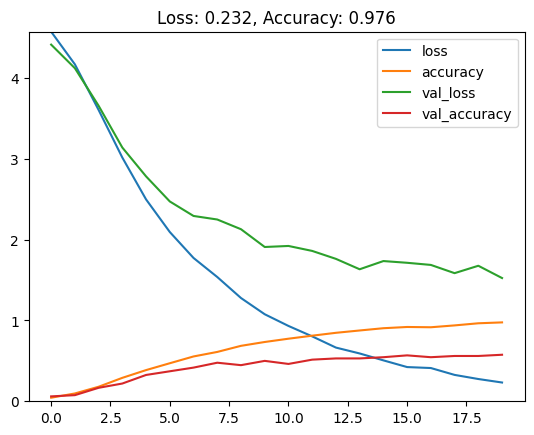

In [30]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

The final exercise for everyone is to try find a group of settings that works the best for them!

There is a script [here ](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) that compares a bunch of different classifiers  see if you can find a network / classifier combination that works better then the what is presented here.

